# Learning curves (111, 119), LS on transfer vs. LS on training

In [30]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import matplotlib.patches as mpatches
import sys
sys.path.append('../..')
from data_import import*
from helper import*
from plot_params import*
from paths import*

In [31]:
pp = PlotParams()
paths = paths()

In [32]:
f4_path = paths.f4_path + '4e9c1cf/'

## Read the data

In [33]:
data = import_and_transform_data(f4_path, 'NOGTHSH_LEARNING_CURVES_4e9c1cf_9A_23_09_05.csv')
data_tag, data = data

In [34]:
######################
## Filter the data: filtering for rt<180, rt > 5000 and random trials, drop RTs above 3std
data = drop_RTs_above_3std_below_180(data)

In [35]:
corr_matrix = (data
                   .groupby(['model', 'participant', 'e_train', 'e_test', 'day'])
                   [['rt','rt_predicted']]
                   .corr())
corr_matrix.reset_index(inplace = True)
corr_matrix.drop(['level_5', 'rt'], axis = 1, inplace = True)
matrix = corr_matrix.loc[corr_matrix['rt_predicted'] !=1]
matrix['r_sqr'] = matrix.rt_predicted**2
matrix.drop('rt_predicted', axis = 1, inplace = True)
matrix;

In [36]:
data_ct_m =  matrix.pivot(index = ['participant', 'day'], columns = 'model', values = 'r_sqr')
data_ct_m['m_ct_diff'] = data_ct_m['iHMM'] - data_ct_m['Markov'] 

## Restructure the data frame 

In [37]:
data_diff = data_ct_m.reset_index()
#data_diff.drop('index', 1, inplace=True)
data_diff = (data_diff
                    .groupby(['participant', 'day'])
                    .mean()        
            )
data_diff = (data_diff
     .stack()
     .reset_index()
      .pivot_table(index = 'participant', columns = ['day', 'model'])
 
)
data_diff.columns = data_diff.columns.droplevel(0)
data_diff;

In [38]:
header1 = ['day_'+ str(int(item[0]))for item in data_diff.columns]
header2 = [item[1] for item in data_diff.columns]
multiindex = pd.MultiIndex.from_arrays([header1, header2], names=["day", "model"])
len(multiindex)
data_diff.columns = multiindex

## Calculate Learning Strength averages

In [39]:
data_diff['avg_diff_d5_8'] = (data_diff
                                  [[('day_5', 'm_ct_diff'), 
                                    ('day_6', 'm_ct_diff'), 
                                    ('day_7', 'm_ct_diff'), 
                                    ('day_8', 'm_ct_diff')]]
                                    .mean(axis = 1))

r=0.559, p=0.004**


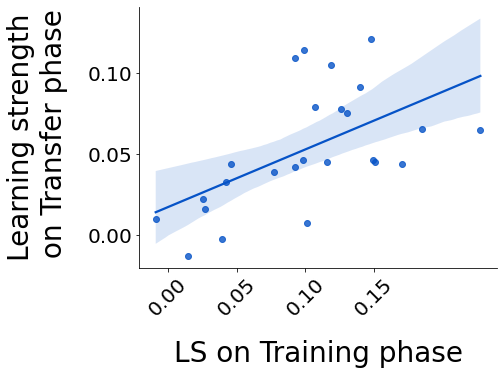

In [40]:
df = data_diff

fig, axs = plt.subplots(figsize = pp.figsize,  facecolor='white')
x, y = df.avg_diff_d5_8, df.day_9.m_ct_diff
sns_plot = sns.regplot(x=x, y=y, color =pp.basic_color)
r, p = sp.stats.pearsonr(x=x, y=y)


#sns_plot.text(-0.01, .105, 'r={:.3f}, p={:.3f}{}'.format(r, p, get_stars(p)), fontsize = 22)
sns_plot.set_xlabel("LS on Training phase", fontsize = pp.axlabsize, labelpad=20)
sns_plot.set_ylabel("Learning strength\n on Transfer phase", fontsize = pp.axlabsize, labelpad = 20)

#sns_plot.yaxis.set_label_coords(-0.16, 0.4)


plt.yticks([0, 0.05, 0.1], fontsize = pp.ticklabsize)
plt.xticks([0, 0.05, 0.1, 0.15], fontsize = pp.ticklabsize, rotation = 45)



sns_plot.spines["top"].set_visible(False)
sns_plot.spines["right"].set_visible(False);


print('r={:.3f}, p={:.3f}{}'.format(r, p, get_stars(p)))

In [41]:
fig.savefig(paths.plot_save_path +'/manuscript_plots_standard/' +'LS_corrplot.pdf', bbox_inches='tight')
fig.savefig(paths.plot_save_path +'/manuscript_plots_standard/' +'LS_corrplot.png', bbox_inches='tight')

## Learning Curve for example participants 

In [42]:
learning_curves = data_ct_m.reset_index()
learning_curves = learning_curves.loc[learning_curves['day'].isin(range(1,9))]

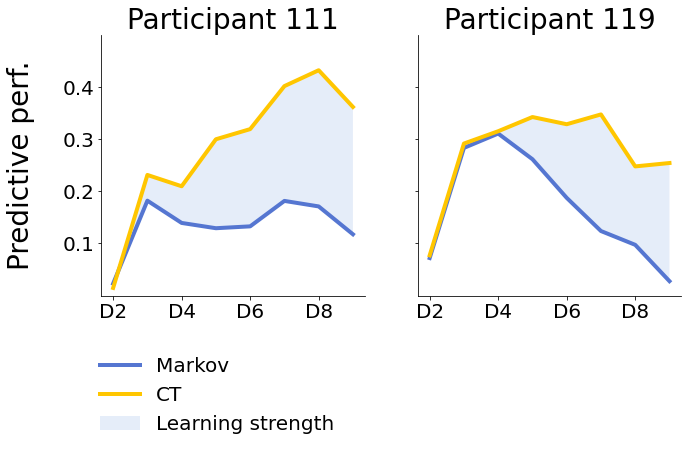

In [43]:
n_row, n_col  = 1,2
participants = [111, 119]
fig, axs = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize = pp.pairfigsize, facecolor = 'white')



r, c = 0,0
for p in participants:
    

    sns_plot = sns.lineplot(ax = axs[c], x = 'day', y = 'Markov', 
                           data = learning_curves.loc[learning_curves['participant']== p],
                           color = pp.markov_blue,
                           lw = 4, 
                           label = 'Markov')
    
    
    sns_plot = sns.lineplot(ax = axs[c], x = 'day', y = 'iHMM',
                               data = learning_curves.loc[learning_curves['participant']== p], 
                               color = pp.ct_orange,
                               lw = 4, 
                                label = 'CT')
    
    
    sns_plot.fill_between(x =range(1,9) , 
                          y1 = learning_curves.loc[learning_curves['participant']== p].Markov,
                          y2 = learning_curves.loc[learning_curves['participant']== p].iHMM,
                          facecolor='#0653C7',
                          alpha=0.1,
                          label = 'Learning strength')

    handles, labels = sns_plot.get_legend_handles_labels()  

    #################
    ## Legend
    #################

    sns_plot.set_title('Participant ' +str(p), fontsize = pp.titlefontsize)
    sns_plot.set(ylim=(0, 0.5))
   
    
    sns_plot.legend([],[], frameon=False)
    
    
    sns_plot.spines["top"].set_visible(False)
    sns_plot.spines["right"].set_visible(False);

    
    
    c += 1
    if c == n_col:
        c = 0
        r+= 1

    for ax in fig.axes:
        sns_plot.set_xlabel(None)
        sns_plot.set_ylabel('Predictive perf.', loc = ('center'), fontsize = pp.axlabsize)
        sns_plot.yaxis.set_label_coords(-0.25, 0.5)
        sns_plot.set_xticks(np.arange(1,9,2));
        sns_plot.set_xticklabels(['D2', 'D4', 'D6', 'D8'], rotation = 0);
        sns_plot.tick_params(axis='both', which='major', labelsize=pp.ticklabsize)
        sns_plot.set_yticks([0.1, 0.2, 0.3, 0.4])

    ################
    #### Ticks, axes & axis labels 
    ################

    
    
fig.legend(handles,
           
#            ["Initial Inductive Bias",
#             "Internal Model", 
#             "Learning Strength"],
            ["Markov", "CT", "Learning strength"],
                    
           
                    fontsize = pp.legendfontsize,
                    bbox_to_anchor=(0.46, 0),
                    title = None,
                    frameon = False);

In [44]:
fig.savefig(paths.plot_save_path +'/manuscript_plots_standard/' +'LS_selected.pdf', bbox_inches='tight')
fig.savefig(paths.plot_save_path +'/manuscript_plots_standard/' +'LS_selected.png', bbox_inches='tight')